In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime
import plotly.express as px
import sklearn

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import eli5 # Feature importance evaluation

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer
from xgboost import plot_importance

C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.
C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

In [2]:
#Definimos el concepto de tn, tp, fn y fp en una matriz de confusión binaria para poder extraerlos en cada iteración del CV:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

# 7. Decision Tree Bagging

### 7.1 Definimos dataset

In [3]:
#Importamos el dataset final
df_final = pd.read_csv("df_final.csv")

In [4]:
df_final.shape

(70349, 23)

### 7.2 Reducir atributos

En este apartado vamos ver cuales son los atributos mas importantes para el modelo. Con esta información podremos ver si el modelo con menos variables es igual de bueno o no. De esta manera tendremos un atributo mucho mas simple y rapido.

Empezamos teniendo los 22 atributos iniciales.

In [5]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","agent","adr","required_car_parking_spaces","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
bagging_model = BaggingClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', bagging_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_bagging22 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_bagging22 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_bagging22[0] = [tn_mean, fp_mean]
cm_bagging22[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_bagging22 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Decision Tree Bagging accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Decision Tree Bagging balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Decision Tree Baggingarea under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Decision Tree Bagging cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Decision Tree Bagging cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Decision Tree Bagging cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Decision Tree Bagging cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Decision Tree Bagging cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Decision Tree Bagging cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Decision Tree Bagging cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_bagging22)

Decision Tree Bagging accuracy score: 0.8594 +/- 0.0043 (std) min: 0.8503, max: 0.8652
Decision Tree Bagging balanced accuracy score: 0.853 +/- 0.0051 (std) min: 0.8441, max: 0.8601
Decision Tree Baggingarea under ROC curve score: 0.9342 +/- 0.0039 (std) min: 0.927, max: 0.9408
Decision Tree Bagging cross validation sensitivity score: 0.8047 +/- 0.0111 (std)
Decision Tree Bagging cross validation specificity score: 0.9012 +/- 0.0041 (std)
Decision Tree Bagging cross validation precision score: 0.8613 +/- 0.0068 (std)
Decision Tree Bagging cross validation NPV score: 0.8581 +/- 0.0072 (std)
Decision Tree Bagging cross validation FNR score: 0.1953 +/- 0.0111 (std)
Decision Tree Bagging cross validation FPR score: 0.0988 +/- 0.0041 (std)
Decision Tree Bagging cross validation F1 score: 0.832 +/- 0.0069 (std)
[[2157.  236.]
 [ 356. 1470.]]


A continuación calcularemos la importancia de cada uno de los atributos usados. En el caso de las variables categóricas su importancia se nos dará desglosada en cada uno de sus posibles valores:

In [6]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Calculamos la importancia haciendo la media de cada arbol
feature_importances = np.mean([
    tree.feature_importances_ for tree in model_pipe['model'].estimators_
], axis=0)

# variable importance: 
imp = {"VarName":feat_imp_list
       , "Importance":feature_importances}

print(pd.DataFrame(imp))
pd.DataFrame(imp).head(50)
imp_df_raw = pd.DataFrame(imp)

                           VarName  Importance
0                        lead_time    0.142634
1         arrival_date_week_number    0.047426
2        arrival_date_day_of_month    0.051540
3          stays_in_weekend_nights    0.020007
4             stays_in_week_nights    0.030325
..                             ...         ...
199           reserved_room_type_G    0.000193
200         customer_type_Contract    0.001040
201            customer_type_Group    0.000116
202        customer_type_Transient    0.016965
203  customer_type_Transient-Party    0.024417

[204 rows x 2 columns]


Hemos mostrado el dataframe anterior porque hemos pensado que podría ser interesante ver que categoría de las variables categóricas tenia más peso. No obstante, realmente nos interesa saber el resultado agregado, por lo que lo calcularemos a partir de los datos anteriores:

In [7]:
#Calcularemos la importancia de cada features sumando las importancias de cada una de las categorias posibles del atributo.
search_values = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","agent","adr","required_car_parking_spaces","total_of_special_requests",
               ]

imp_df_num = imp_df_raw[imp_df_raw.VarName.str.contains('|'.join(search_values ))]


arrival_date_month = imp_df_raw[imp_df_raw['VarName'].str.contains("arrival_date_month")]
meal = imp_df_raw[imp_df_raw['VarName'].str.contains("meal")]
country = imp_df_raw[imp_df_raw['VarName'].str.contains("country")]
market_segment = imp_df_raw[imp_df_raw['VarName'].str.contains("market_segment")]
distribution_channel = imp_df_raw[imp_df_raw['VarName'].str.contains("distribution_channel")]
reserved_room_type = imp_df_raw[imp_df_raw['VarName'].str.contains("reserved_room_type")]
customer_type = imp_df_raw[imp_df_raw['VarName'].str.contains("customer")]

array = np.zeros(shape=(7,1))

array[0] = arrival_date_month.Importance.sum()
array[1] = meal.Importance.sum()
array[2] = country.Importance.sum()
array[3] = market_segment.Importance.sum()
array[4] = distribution_channel.Importance.sum()
array[5] = reserved_room_type.Importance.sum()
array[6] = customer_type.Importance.sum()

dict = {'VarName': ['arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']
                 , 'Importance': array[:,0]}

imp_dict = pd.DataFrame(dict)

imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)

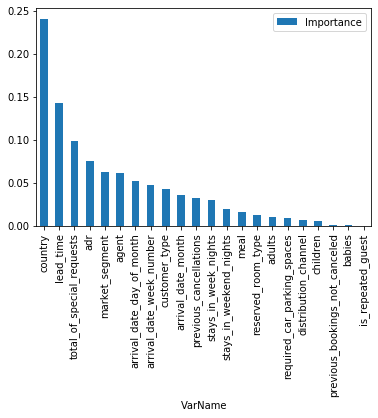

In [8]:
pd.DataFrame(imp_df_final).sort_values(by = 'Importance', ascending=False).head(30).plot.bar(x = 'VarName')

Eliminamos los 10 atributos menos importantes, quedandonos asi con un total de 12 variables

In [9]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_week_nights","previous_cancellations","agent","adr","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","country","market_segment","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
bagging_model = BaggingClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', bagging_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_bagging12 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_bagging12 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_bagging12[0] = [tn_mean, fp_mean]
cm_bagging12[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_bagging12 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Decision Tree Bagging accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Decision Tree Bagging balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Decision Tree Baggingarea under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Decision Tree Bagging cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Decision Tree Bagging cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Decision Tree Bagging cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Decision Tree Bagging cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Decision Tree Bagging cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Decision Tree Bagging cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Decision Tree Bagging cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_bagging12)

Decision Tree Bagging accuracy score: 0.8565 +/- 0.004 (std) min: 0.8503, max: 0.8633
Decision Tree Bagging balanced accuracy score: 0.8497 +/- 0.0049 (std) min: 0.8407, max: 0.8586
Decision Tree Baggingarea under ROC curve score: 0.9298 +/- 0.004 (std) min: 0.922, max: 0.9369
Decision Tree Bagging cross validation sensitivity score: 0.799 +/- 0.0122 (std)
Decision Tree Bagging cross validation specificity score: 0.9005 +/- 0.0046 (std)
Decision Tree Bagging cross validation precision score: 0.8596 +/- 0.0072 (std)
Decision Tree Bagging cross validation NPV score: 0.8545 +/- 0.008 (std)
Decision Tree Bagging cross validation FNR score: 0.201 +/- 0.0122 (std)
Decision Tree Bagging cross validation FPR score: 0.0995 +/- 0.0046 (std)
Decision Tree Bagging cross validation F1 score: 0.8281 +/- 0.0067 (std)
[[2155.  238.]
 [ 367. 1459.]]


A continuación calcularemos la importancia de cada uno de los atributos usados. En el caso de las variables categóricas su importancia se nos dará desglosada en cada uno de sus posibles valores:

In [10]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Calculamos la importancia haciendo la media de cada arbol
feature_importances = np.mean([
    tree.feature_importances_ for tree in model_pipe['model'].estimators_
], axis=0)

# variable importance: 
imp = {"VarName":feat_imp_list
       , "Importance":feature_importances}

print(pd.DataFrame(imp))
pd.DataFrame(imp).head(50)
imp_df_raw = pd.DataFrame(imp)

                           VarName  Importance
0                        lead_time    0.158562
1         arrival_date_week_number    0.055134
2        arrival_date_day_of_month    0.062953
3             stays_in_week_nights    0.038037
4           previous_cancellations    0.032431
..                             ...         ...
177       market_segment_Online TA    0.056073
178         customer_type_Contract    0.001234
179            customer_type_Group    0.000169
180        customer_type_Transient    0.017209
181  customer_type_Transient-Party    0.025490

[182 rows x 2 columns]


Hemos mostrado el dataframe anterior porque hemos pensado que podría ser interesante ver que categoría de las variables categóricas tenia más peso. No obstante, realmente nos interesa saber el resultado agregado, por lo que lo calcularemos a partir de los datos anteriores:

In [11]:
#Calcularemos la importancia de cada features sumando las importancias de cada una de las categorias posibles del atributo.
search_values = num_features

imp_df_num = imp_df_raw[imp_df_raw.VarName.str.contains('|'.join(search_values ))]


arrival_date_month = imp_df_raw[imp_df_raw['VarName'].str.contains("arrival_date_month")]

country = imp_df_raw[imp_df_raw['VarName'].str.contains("country")]
market_segment = imp_df_raw[imp_df_raw['VarName'].str.contains("market_segment")]

customer_type = imp_df_raw[imp_df_raw['VarName'].str.contains("customer")]

array = np.zeros(shape=(4,1))

array[0] = arrival_date_month.Importance.sum()

array[1] = country.Importance.sum()
array[2] = market_segment.Importance.sum()

array[3] = customer_type.Importance.sum()


dict = {'VarName': ['arrival_date_month',

 'country',
 'market_segment',

 'customer_type']
                 , 'Importance': array[:,0]}

imp_dict = pd.DataFrame(dict)

imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)

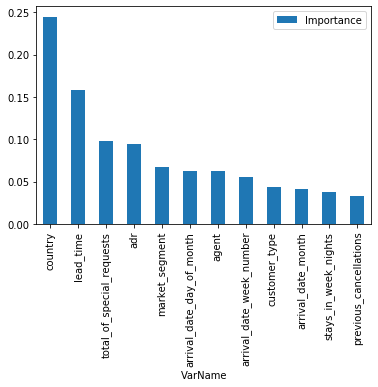

In [12]:
pd.DataFrame(imp_df_final).sort_values(by = 'Importance', ascending=False).head(30).plot.bar(x = 'VarName')

Ahora, eliminamos los 8 atributos menos importantes, quedandonos asi con un total de solo 4 variables

In [13]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time", "adr","total_of_special_requests"]
,
cat_features = ["country"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
bagging_model = BaggingClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', bagging_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_bagging4 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_bagging4 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_bagging4[0] = [tn_mean, fp_mean]
cm_bagging4[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_bagging4 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Decision Tree Bagging accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Decision Tree Bagging balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Decision Tree Baggingarea under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Decision Tree Bagging cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Decision Tree Bagging cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Decision Tree Bagging cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Decision Tree Bagging cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Decision Tree Bagging cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Decision Tree Bagging cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Decision Tree Bagging cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_bagging4)

Decision Tree Bagging accuracy score: 0.8087 +/- 0.0043 (std) min: 0.8012, max: 0.8143
Decision Tree Bagging balanced accuracy score: 0.7992 +/- 0.0056 (std) min: 0.7881, max: 0.8052
Decision Tree Baggingarea under ROC curve score: 0.8806 +/- 0.0053 (std) min: 0.8723, max: 0.8888
Decision Tree Bagging cross validation sensitivity score: 0.729 +/- 0.0126 (std)
Decision Tree Bagging cross validation specificity score: 0.8695 +/- 0.0054 (std)
Decision Tree Bagging cross validation precision score: 0.81 +/- 0.0082 (std)
Decision Tree Bagging cross validation NPV score: 0.8079 +/- 0.0062 (std)
Decision Tree Bagging cross validation FNR score: 0.271 +/- 0.0126 (std)
Decision Tree Bagging cross validation FPR score: 0.1305 +/- 0.0054 (std)
Decision Tree Bagging cross validation F1 score: 0.7673 +/- 0.0087 (std)
[[2081.  312.]
 [ 495. 1332.]]


A continuación calcularemos la importancia de cada uno de los atributos usados. En el caso de las variables categóricas su importancia se nos dará desglosada en cada uno de sus posibles valores:

In [14]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Calculamos la importancia haciendo la media de cada arbol
feature_importances = np.mean([
    tree.feature_importances_ for tree in model_pipe['model'].estimators_
], axis=0)

# variable importance: 
imp = {"VarName":feat_imp_list
       , "Importance":feature_importances}

print(pd.DataFrame(imp))
pd.DataFrame(imp).head(50)
imp_df_raw = pd.DataFrame(imp)

                       VarName  Importance
0                    lead_time    0.325333
1                          adr    0.304627
2    total_of_special_requests    0.071179
3                  country_ABW    0.000000
4                  country_AGO    0.004474
..                         ...         ...
149                country_VEN    0.000412
150                country_VGB    0.000000
151                country_VNM    0.000067
152                country_ZAF    0.000623
153                country_ZWE    0.000000

[154 rows x 2 columns]


Hemos mostrado el dataframe anterior porque hemos pensado que podría ser interesante ver que categoría de las variables categóricas tenia más peso. No obstante, realmente nos interesa saber el resultado agregado, por lo que lo calcularemos a partir de los datos anteriores:

In [15]:
#Calcularemos la importancia de cada features sumando las importancias de cada una de las categorias posibles del atributo.
search_values = num_features

imp_df_num = imp_df_raw[imp_df_raw.VarName.str.contains('|'.join(search_values ))]




country = imp_df_raw[imp_df_raw['VarName'].str.contains("country")]


array = np.zeros(shape=(1,1))



array[0] = country.Importance.sum()



dict = {'VarName': ['country']
                 , 'Importance': array[:,0]}

imp_dict = pd.DataFrame(dict)

imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)

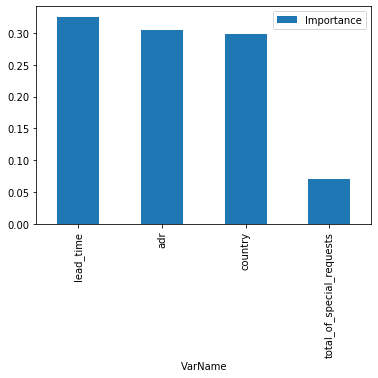

In [16]:
pd.DataFrame(imp_df_final).sort_values(by = 'Importance', ascending=False).head(30).plot.bar(x = 'VarName')

In [17]:
#Juntamos los resultados obtenidos con cada modelo:
bagging_parameters = np.zeros(shape=(3,7))
bagging_parameters[0] = model_results_bagging22
bagging_parameters[1] = model_results_bagging12
bagging_parameters[2] = model_results_bagging4

#Creamos un diccionario para pasar los resultados a un dataframe:
bagging_parameters_dict = {'Model': ['Bagging 22 var', 'Bagging 12 var', 'Bagging 4 var']
                 , 'Accuracy': bagging_parameters[:,0],'Balanced accuracy': bagging_parameters[:,1],'ROC AUC': bagging_parameters[:,2],'TN': bagging_parameters[:,3],'FP': bagging_parameters[:,4],'FN': bagging_parameters[:,5],'TP': bagging_parameters[:,6]}

bagging_parameters_df = pd.DataFrame.from_dict(bagging_parameters_dict)
bagging_parameters_df

,Model,Accuracy,Balanced accuracy,ROC AUC,TN,FP,FN,TP
0,Bagging 22 var,0.8594,0.8530,0.9342,2157.0,236.0,356.0,1470.0
1,Bagging 12 var,0.8565,0.8497,0.9298,2155.0,238.0,367.0,1459.0
2,Bagging 4 var,0.8087,0.7992,0.8806,2081.0,312.0,495.0,1332.0


Text(0.5, 1.0, 'Area under ROC curve VS # of variables')

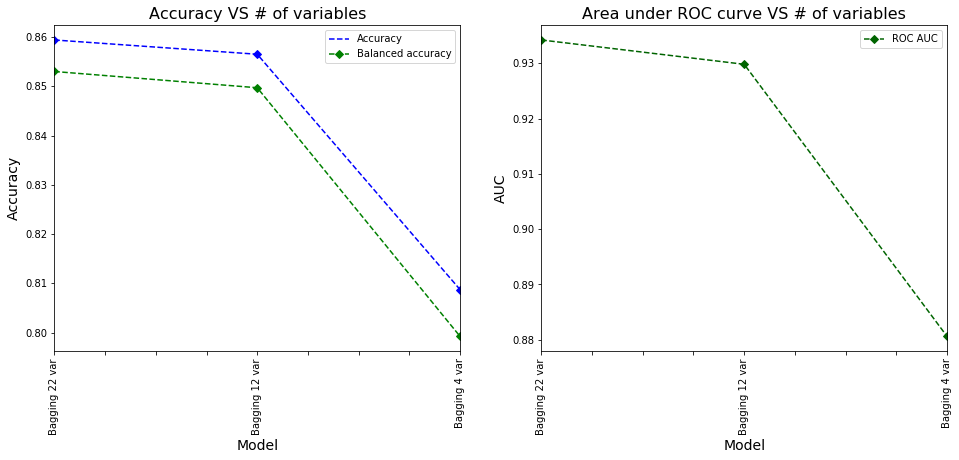

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))
a = bagging_parameters_df.plot(kind='line',x='Model',y='Accuracy',ax=ax1, rot = 90, color = 'blue',linestyle ='--', marker='D')
bagging_parameters_df.plot(kind='line',x='Model',y='Balanced accuracy', color='green', ax=ax1, rot = 90,linestyle ='--', marker='D')
a.set_title('Accuracy VS # of variables', fontsize = 16)
a.set_xlabel('Model', fontsize = 14)
a.set_ylabel('Accuracy', fontsize = 14)

b = bagging_parameters_df.plot(kind='line',x='Model',y='ROC AUC', rot = 90, color = 'DarkGreen',linestyle ='--', marker='D',ax=ax2)
b.set_xlabel('Model', fontsize = 14)
b.set_ylabel('AUC', fontsize = 14)
plt.title('Area under ROC curve VS # of variables', fontsize = 16)

### 7.3 Ajustar hiperparametros

In [19]:
#Nos hemos quedado con el modelo de 12 variables

num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_week_nights","previous_cancellations","agent","adr","total_of_special_requests"]
cat_features = ["arrival_date_month","country","market_segment","customer_type"]

features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]


#Codificamos las variables categóricas:
ct = make_column_transformer(
    (OneHotEncoder(),cat_features), remainder = 'passthrough')

#Convertimos X en un array:
X = ct.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [20]:
X_train.shape

(42209, 196)

#### 7.3.1 n_estimators

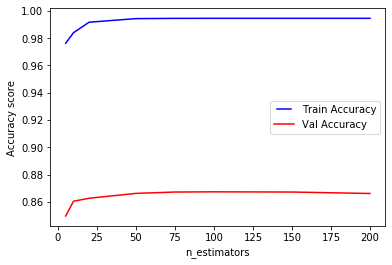

In [21]:
estimadores = [5,10,20,50,75,100,150,200]
train_results = []
test_results = []
for estimador in estimadores:
    dt = BaggingClassifier(n_estimators=estimador)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train Accuracy")
line2, = plt.plot(estimadores, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("n_estimators")
plt.show()

iteracion 5 realizada
iteracion 10 realizada
iteracion 20 realizada
iteracion 50 realizada
iteracion 75 realizada


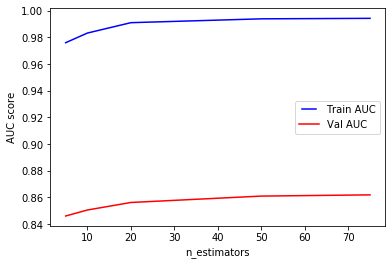

In [22]:
estimadores = [5,10,20,50,75]
train_results = []
test_results = []
for estimador in estimadores:
    dt = BaggingClassifier(n_estimators=estimador)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", estimador, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train AUC")
line2, = plt.plot(estimadores, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

Nos quedamos con el valor el valor n_estimadors=20.

#### 7.3.2 max_samples

iteration 0.1 hecha
iteration 0.2 hecha
iteration 0.3 hecha
iteration 0.4 hecha
iteration 0.5 hecha
iteration 0.6 hecha
iteration 0.7 hecha
iteration 0.8 hecha
iteration 0.9 hecha
iteration 1.0 hecha


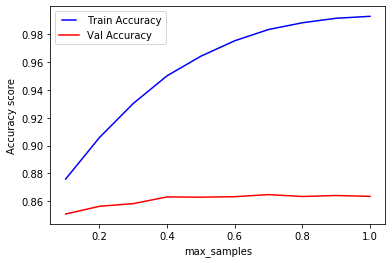

In [23]:
max_samples = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_results = []
test_results = []
for max_sample in max_samples:
    dt = BaggingClassifier(n_estimators=25, max_samples= max_sample)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
    print("iteration", max_sample, "hecha")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_samples, train_results, "b", label="Train Accuracy")
line2, = plt.plot(max_samples, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("max_samples")
plt.show()

iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada
iteracion 75 realizada


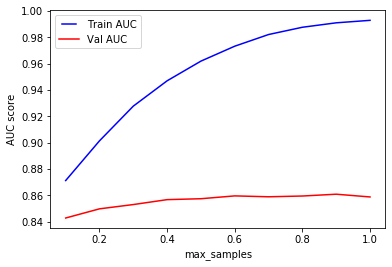

In [24]:
max_samples = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_results = []
test_results = []
for max_sample in max_samples:
    dt = BaggingClassifier(n_estimators=25, max_samples= max_sample)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", estimador, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_samples, train_results, "b", label="Train AUC")
line2, = plt.plot(max_samples, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_samples")
plt.show()

Nos quedamos con el valor que de max_samples que estaba asignado por defecto, el 1. Ya que este valor es el mejor observando las accuracy y el area bajo de la curva ROC.

### 7.4 Modelo final

In [25]:
bagging_final_model = BaggingClassifier(n_estimators=25)
bagging_final_model

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=25,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [27]:
bagging_final_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=25,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [28]:
#Calculamos los valores que obtenemos de nuestros datos de test
y_pred=bagging_final_model.predict(X_test)

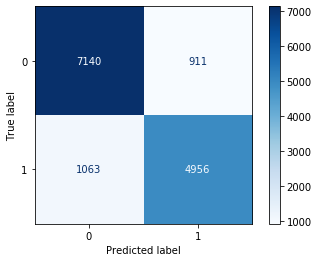

In [29]:
sklearn.metrics.plot_confusion_matrix(bagging_final_model, X_test, y_test, values_format="d", cmap=plt.cm.Blues)  # doctest: +SKIP
plt.show()

In [31]:
accuracy= sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy_balanced= sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
probs = bagging_final_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc= metrics.auc(fpr, tpr)
f1= sklearn.metrics.f1_score(y_test, y_pred)

In [32]:
results_dict = {'Model': ['Decision tree Bagging']
                 , 'Accuracy': accuracy,'Balanced accuracy': accuracy_balanced,'ROC AUC': roc, 'F1 Score': f1}

model_results_df = pd.DataFrame.from_dict(results_dict)
model_results_df

,Model,Accuracy,Balanced accuracy,ROC AUC,F1 Score
0,Decision tree Bagging,0.859701,0.855119,0.938985,0.833922


In [33]:
model_results_df.to_csv('df_bagging_final.csv', index=False)

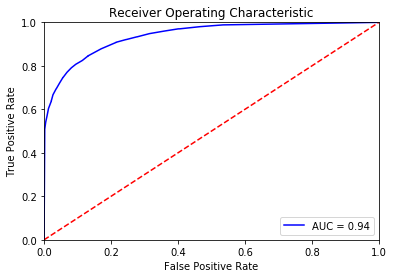

In [34]:
probs = bagging_final_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc= metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
from sklearn.metrics import classification_report
h=classification_report(y_test, y_pred)

In [36]:
print(h)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8051
           1       0.84      0.82      0.83      6019

    accuracy                           0.86     14070
   macro avg       0.86      0.86      0.86     14070
weighted avg       0.86      0.86      0.86     14070



In [38]:
results_dict = {'Model': ['Decision Tree Bagging']
                 , 'Accuracy': accuracy,'Balanced accuracy': accuracy_balanced,'ROC AUC': roc, 'F1 Score': f1, 'sensitivity':0.82, 'specificity':0.89}

model_results_df = pd.DataFrame.from_dict(results_dict)
model_results_df

,Model,Accuracy,Balanced accuracy,ROC AUC,F1 Score,sensitivity,specificity
0,Decision Tree Bagging,0.859701,0.855119,0.938985,0.833922,0.82,0.89


In [39]:
model_results_df.to_csv('df_bagging_final.csv', index=False)